# Music Genre Classification with Deep Learning

This tutorial shows how different Convolutional Neural Network architectures are used for the taks of music genre classification.

The data set used is the [GTZAN](http://marsyasweb.appspot.com/download/data_sets/) genre data set compiled by George Tzanetakis. It consists of 1000 tracks (30 second excerpts) from 10 genres, each with 100 examples.

The original tracks are 22050Hz Mono 16-bit audio files in .au format.

For a more compact download we provide a version in .mp3 format, also 22050 Hz.

This tutorial contains:
* Loading and preprocessing of audio files
* Loading class files from CSV and using Label Encoder
* using One-Hot Encoder to prepare class data for Deep Learning
* Generating Mel spectrograms from the audio
* Standardization of data
* Train/Test set split
* Stratified splits
* Convolutional Neural Networks: single, stacked, parallel
* ReLU Activation
* Dropout
* Batch Normalization

(entensions for later:)
* Majority Vote / Max Probability 
* Recurrent Neural Networks
* Cross-validation

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

In [1]:
import sys
# check which python is used
sys.executable

'/media/bagustris/atmaja/workshops/2017/mir-summerschool/DL_MIR_Tutorial2/pymir/bin/python2'

In [2]:
# General Imports

import os

# choosing between CPU and GPU
#device = 'cpu' # 'cpu' or 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation
from os.path import join

# Machine Learning Preprocessing and Evaluation

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import __version__ as sklearn_version

if sklearn_version.startswith('0.17'):
    from sklearn.cross_validation import train_test_split
    from sklearn.cross_validation import StratifiedShuffleSplit
else: # >= 0.18
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedShuffleSplit

# Deep Learning

from theano import config

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

# Plotting

import matplotlib.pyplot as plt
%matplotlib inline 

# Local imports
import rp_extract as rp
from audiofile_read import audiofile_read

# For reading AU file
import sunau


Using Theano backend.


## Set the Path to the Dataset

adjust this path to where the data set is stored on your computer:


In [3]:
# SET YOUR OWN PATH HERE
AUDIO_PATH = './genres/'

## Load the Metadata

The tab-separated file contains pairs of filename TAB class category (i.e. genre).

In [24]:
# csv_file = join(AUDIO_PATH,'filelist_GTZAN_wav_wclasses.txt')   # previous config
csv_file = 'filelist_GTZAN_wav_wclasses.txt'
metadata = pd.read_csv(csv_file, index_col=0, header=None)
metadata.head(10)

,1
0,
./rock/rock.00053.wav,rock
./rock/rock.00051.wav,rock
./rock/rock.00076.wav,rock
./rock/rock.00084.wav,rock
./rock/rock.00052.wav,rock
./rock/rock.00057.wav,rock
./rock/rock.00028.wav,rock
./rock/rock.00035.wav,rock
./rock/rock.00095.wav,rock


In [25]:
# create list of filenames with associated classes
filelist = metadata.index.tolist()
classes = metadata[1].values.tolist()

## Encode Labels to Numbers

String labels need to be encoded as numbers. We use the LabelEncoder from the scikit-learn package.

In [26]:
classes[0:5]

['rock', 'rock', 'rock', 'rock', 'rock']

In [27]:
classes[99:105]

['rock', 'hiphop', 'hiphop', 'hiphop', 'hiphop', 'hiphop']

In [28]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(classes)

# we keep (and print) the number of classis
n_classes = len(labelencoder.classes_)
print n_classes, "classes:", ", ".join(list(labelencoder.classes_))

classes_num = labelencoder.transform(classes)

10 classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock


We check how the classes look like now numerically:

In [29]:
classes_num[0:5]

array([9, 9, 9, 9, 9])

In [30]:
classes_num[99:105]

array([9, 4, 4, 4, 4, 4])

Note: In order to correctly re-transform any predicted numbers into strings, we keep the labelencoder for later.

In [31]:
from sklearn.preprocessing import OneHotEncoder

# make a row vector a column vector, as needed by OneHotEncoder, using reshape(-1,1) 
classes_num_col = classes_num.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
classes_num_1hot = encoder.fit_transform(classes_num_col)
classes_num_1hot

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [32]:
classes_num_1hot.shape

(997, 10)

## Load the Audio Files

In [33]:

list_spectrograms = [] # spectrograms are put into a list first

# desired output parameters
n_mel_bands = 40   # y axis
frames = 80        # x axis

# some FFT parameters
fft_window_size=1024 #512
fft_overlap = 0.5
hop_size = int(fft_window_size*(1-fft_overlap))
segment_size = fft_window_size + (frames-1) * hop_size # segment size for desired # frames

for filename in filelist:
    print ".", 
    filepath = os.path.join(AUDIO_PATH, filename)
    samplerate, samplewidth, wavedata = audiofile_read(filepath,verbose=False)
    sample_length = wavedata.shape[0]

    # make Mono (in case of multiple channels / stereo)
    if wavedata.ndim > 1:
        wavedata = np.mean(wavedata, 1)
      
    # GET AUDIO SEGMENT (BLOCK)
    # take only 1 audio segment (80 frames)
    # a) from beginning of file
    #pos = 0
    # b) from middle of file
    pos = int(sample_length / 2 - segment_size / 2)
    wav_segment = wavedata[pos:pos+segment_size]
    
    # AUDIO PRE-PROCESSING

    # 1) FFT spectrogram 
    spectrogram = rp.calc_spectrogram(wav_segment,fft_window_size,fft_overlap)

    # 2) Transform to perceptual Mel scale (uses librosa.filters.mel)
    spectrogram = rp.transform2mel(spectrogram,samplerate,fft_window_size,n_mel_bands)
        
    # 3) Log 10 transform
    spectrogram = np.log10(spectrogram)
    
    list_spectrograms.append(spectrogram)
        
print "\nRead", len(filelist), "audio files"

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [34]:
print "Duration of input audio file:"
print sample_length / samplerate, "seconds"

Duration of input audio file:
30 seconds


In [35]:
print "An audio segment is", round(float(segment_size) / samplerate, 2), "seconds long"

An audio segment is 1.88 seconds long


In [36]:
# how many spectrograms did we get
len(list_spectrograms)

997

In [37]:
# whats the shape of 1 spectrogram: 40 Mel bands by 80 frames
spectrogram.shape

(40, 80)

Note: For simplicity of this tutorial, here we load only 1 single segment of ~ 1 second length from each audio file.
In a real setting, one would create training instances of as many audio segments as possible to be fed to a Neural Network.

In [38]:
spectrogram[0:5,0:5]

array([[-2.21706899, -2.13685759, -1.93284517, -1.85325874, -1.92972802],
       [-1.68157686, -1.68318277, -1.8303628 , -2.0573346 , -2.11926532],
       [-2.12279533, -2.36054293, -2.30594199, -1.76131269, -1.47456052],
       [-2.18641389, -2.30344135, -2.33540736, -2.13075122, -1.94464886],
       [-2.31179852, -3.05191259, -3.52575675, -3.56628314, -4.17664073]])

In [39]:
# TODO plot spectrogram

## Make 1 big array of list of spectrograms

In [40]:
# a list of many 40x80 spectrograms is made into 1 big array
# config.floatX is from Theano configration to enforce float32 precision (needed for GPU computation)
data = np.array(list_spectrograms, dtype=config.floatX)
data.shape

(997, 40, 80)

In [41]:
# check for Inf values

# np.log10(spectrogram) will produce -inf if a spectrogram value is 0. we replace -inf by 0 here

if np.any(np.isinf(data)):
    print "Warning: Data contains inf values. Replacying by 0."
    data[np.isinf(data)] = 0

## Standardization

<b>Always normalize / standardize</b> the data before feeding it into the Neural Network!

We use <b>attribute-wise standardization</b>, i.e. each feature (i.e. 'pixel' in the spectrogram) is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

(Instead of 'attribute-wise, also 'flat' standardization would also be possible,computing the mean and standard deviation across all pixels).

One possibility is 'Min-Max normalization', i.e. scaling the values between 0 and 1.

Here we use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).

We use the StandardScaler from the scikit-learn package for our purpose, which performs a Zero-mean Unit-variance standardization.

In [42]:
# Scalers and normalizers work on vectors. So we have to transfor the matrix of our spectrograms into vector data
# ('vectorize' or 'reshape' them).

# vectorize
N, ydim, xdim = data.shape
data = data.reshape(N, xdim*ydim)
data.shape

(997, 3200)

In [43]:
data[0:1].shape

(1, 3200)

In [44]:
# standardize
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

Now all the values are transformed into the 0-mean 1-variance space.

In [45]:
np.mean(data, axis=0)

array([ 0.00000078,  0.00000059,  0.00000067,  0.00000031, -0.0000008 , -0.00000036,  0.00000103, -0.00000021,  0.00000067,  0.00000045, ..., -0.00000327, -0.000001  , -0.00000153,  0.00000032,
        0.00000032, -0.00000134,  0.00000067, -0.00000161, -0.0000007 ,  0.00000041], dtype=float32)

In [46]:
np.std(data, axis=0)

array([1.0000004 , 0.9999997 , 1.        , 0.9999996 , 0.9999999 , 0.9999996 , 0.99999976, 1.0000001 , 0.99999976, 0.99999917, ..., 1.0000002 , 0.9999998 , 1.        , 1.        , 1.        ,
       1.0000002 , 0.9999994 , 1.0000002 , 0.99999964, 1.0000001 ], dtype=float32)

In [47]:
# scaler stores the original values to be able to transform later again
# show mean and standard deviation: two vectors with same length as data.shape[1]
scaler.mean_, scaler.scale_

(array([-2.8433895, -2.864513 , -2.8402867, -2.8526828, -2.8371346, -2.8278828, -2.8229005, -2.8337243, -2.838455 , -2.824339 , ..., -7.901412 , -7.917027 , -7.885189 , -7.870407 , -7.8833413,
        -7.9073334, -7.8950214, -7.9078255, -7.9078665, -7.916666 ], dtype=float32),
 array([1.2382029, 1.2369902, 1.2256765, 1.2309545, 1.2586452, 1.2256727, 1.2132349, 1.2043762, 1.1990461, 1.2110823, ..., 2.0765793, 2.0491145, 2.0941658, 2.106527 , 2.1106267, 2.0975487, 2.0893266,
        2.0872352, 2.0949612, 2.0953429], dtype=float32))

# Creating Train & Test Set 

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Here we compare Random Split vs. Stratified Split:

In [48]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

# RANDOM split of data set into 2 parts
# from sklearn.model_selection import train_test_split

train_set, test_set, train_classes, test_classes = train_test_split(data, classes_num, test_size=testset_size, random_state=0)

In [49]:
train_classes

array([5, 3, 9, 9, 1, 0, 2, 2, 3, 4, ..., 7, 9, 6, 7, 7, 0, 4, 8, 1, 8])

In [50]:
test_classes

array([3, 7, 9, 6, 8, 7, 1, 3, 0, 3, ..., 5, 2, 8, 9, 5, 9, 5, 5, 6, 5])

In [51]:
from collections import Counter
cnt = Counter(train_classes)

print "Number of files in each category in TRAIN set:"
for k in sorted(cnt.keys()):
    print k, ":", cnt[k]

Number of files in each category in TRAIN set:
0 : 75
1 : 77
2 : 77
3 : 73
4 : 82
5 : 71
6 : 72
7 : 74
8 : 68
9 : 78


In a Random Split, the number of files per class may be uneven or unbalanced.

The better way to do it is to use a <b>Stratified Split</b>:

In [52]:
# better: Stratified Split retains the class balance in both sets
# from sklearn.model_selection import StratifiedShuffleSplit

if sklearn_version.startswith('0.17'):
    splits = StratifiedShuffleSplit(classes_num, n_iter=1, test_size=testset_size, random_state=0)
else: # >= 0.18:
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
    splits = splitter.split(data, classes_num)

for train_index, test_index in splits:
    print "TRAIN INDEX:", train_index
    print "TEST INDEX:", test_index
    
    # split the data
    train_set = data[train_index]
    test_set = data[test_index]
    
    # and the numeric classes (groundtruth)
    train_classes = classes_num[train_index]
    train_classes_1hot = classes_num_1hot[train_index]  # 1 hot we need for traning
    test_classes = classes_num[test_index]
# Note: this for loop is only executed once, if n_splits==1

print train_set.shape
print test_set.shape
# Note: we will reshape the data later back to matrix form 

TRAIN INDEX: [933 813 580 848 767 229 248 357 134 935 ... 364 618 174  13 326 436 641  29 135  39]
TEST INDEX: [531 951 352 790 623 287  80  23 507 435 ... 979 433 480 249 486 869 874 555 885 984]
(747, 3200)
(250, 3200)


In [53]:
cnt = Counter(train_classes)
print "Number of files in each category in TRAIN set:"
for k in sorted(cnt.keys()):
    print k, ":", cnt[k]

Number of files in each category in TRAIN set:
0 : 75
1 : 75
2 : 75
3 : 75
4 : 73
5 : 75
6 : 74
7 : 75
8 : 75
9 : 75


Now the number of files in each category in the training set is equal.

(It is equal because our full set had 100 files in each category; a Stratified Split preserves the relative distribution of instances per category, also if the dataset is unbalanced between the classess.)

# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were invented for image data (often having 3 color channels), we need to add a dimension for the color channel to the data. 

<b>Spectrograms, are considered like greyscale images, which only have 1 color channel. Still we add the extra dimension, defining just 1 channel.</b>

#### Theano vs. Tensorflow

In Theano, traditionally the color channel is the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured now in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" with "tf" (Tensorflow) being the default image ordering even though you use Theano. Depending on this, use one of the code lines below.

We created an 'if' statement here to check which dimension ordering to use:

In [54]:
n_channels = 1 # 1 for grey-scale, 3 for RGB (in this case usually already present in the data)

if keras.backend.image_dim_ordering() == 'th':
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_set = train_set.reshape(train_set.shape[0], n_channels, ydim, xdim)
    test_set = test_set.reshape(test_set.shape[0], n_channels, ydim, xdim)
else:
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_set = train_set.reshape(train_set.shape[0], ydim, xdim, n_channels)
    test_set = test_set.reshape(test_set.shape[0], ydim, xdim, n_channels)

In [55]:
keras.backend.image_dim_ordering()

'th'

In [56]:
train_set.shape

(747, 1, 40, 80)

In [57]:
test_set.shape

(250, 1, 40, 80)

In [58]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
input_shape = train_set.shape[1:]  
input_shape

(1, 40, 80)

# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

## Creating a Single Layer and a Two Layer CNN

Try: (comment/uncomment code in the following code block)
* 1 Layer
* 2 Layer
* more conv_filters
* Dropout

In [59]:
np.random.seed(0) # make results repeatable

model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
#conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, 3, 3, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(Dropout(0.25)) 

# Layer 2
model.add(Convolution2D(conv_filters, 3, 3))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid')) 
#model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, for multi-class/multi-label problems use n output units 
# activation should be 'softmax' for multi-class / single-label output, 'sigmoid' for binary or multi-label tasks
model.add(Dense(n_classes,activation='softmax'))

If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

In [60]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 38, 78)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 19, 39)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 17, 37)    2320        maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 16, 8, 18)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Training the CNN

In [61]:
# Define a loss function 
loss = 'categorical_crossentropy' 

# Note: for binary classification (2 classes) OR for multi-class problems use:
#loss = 'binary_crossentropy' 

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [62]:
history = None

In [63]:
# TRAINING the model

# YOU MAY RUN THIS CELL MULTIPLE TIMES TO CONTINUE TO TRAIN THE MODEL FURTHER

# for how many epochs (iterations) to train
epochs = 15

# for training we need the "1 hot encoded" numeric classes of the ground truth
History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
# we append this to previous history in case we execute this cell multiple times
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Epoch 1/15
747/747 [==============================] - 1s - loss: 2.3427 - acc: 0.1633     
Epoch 2/15
747/747 [==============================] - 1s - loss: 2.1124 - acc: 0.2289     
Epoch 3/15
747/747 [==============================] - 1s - loss: 2.0309 - acc: 0.2691     
Epoch 4/15
747/747 [==============================] - 1s - loss: 1.9834 - acc: 0.2959     
Epoch 5/15
747/747 [==============================] - 1s - loss: 1.9424 - acc: 0.3226     
Epoch 6/15
747/747 [==============================] - 1s - loss: 1.9023 - acc: 0.3320     
Epoch 7/15
747/747 [==============================] - 1s - loss: 1.8656 - acc: 0.3454     
Epoch 8/15
747/747 [==============================] - 1s - loss: 1.8356 - acc: 0.3655     
Epoch 9/15
747/747 [==============================] - 1s - loss: 1.8016 - acc: 0.3722     
Epoch 10/15
747/747 [==============================] - 1s - loss: 1.7663 - acc: 0.3949     
Epoch 11/15
747/747 [==============================] - 1s - loss: 1.7397 - acc: 0.3949   

In [64]:
def plot_traincurve(history):
    # define 4 colors for up to 4 different values in history
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

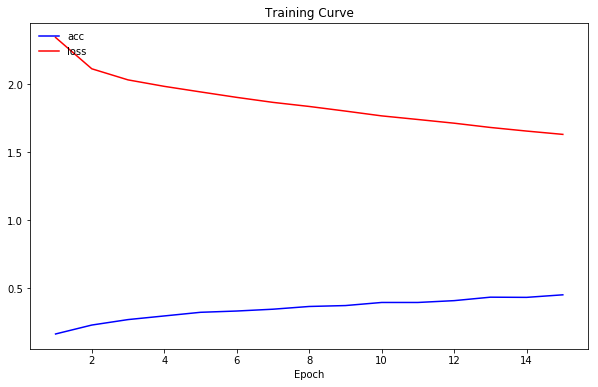

In [65]:
plot_traincurve(history)

#### Accuracy always goes up on Train set! Also on Test set?

### Verifying Accuracy on Test Set

In [66]:
test_pred = model.predict_classes(test_set)

192/250 [======================>.......] - ETA: 0s

In [67]:
# predictions
test_pred

array([1, 2, 6, 8, 8, 4, 4, 6, 1, 1, ..., 2, 1, 5, 3, 2, 4, 9, 1, 2, 1])

In [68]:
# groundtruth
test_classes

array([1, 2, 6, 7, 8, 3, 9, 9, 1, 5, ..., 2, 5, 5, 3, 5, 0, 0, 1, 0, 2])

In [69]:
# 1 layer
accuracy_score(test_classes, test_pred)

0.348

In [70]:
# 2 layer
accuracy_score(test_classes, test_pred)

0.348

In [71]:
# 2 layer + 32 convolution filters
accuracy_score(test_classes, test_pred)

0.348

In [72]:
# 2 layer + 32 convolution filters + ReLU + Dropout
accuracy_score(test_classes, test_pred)

0.348

## Custom Model

In [73]:
# Try to vary these parameters:

conv_filters = 16  # number of convolution filters (= CNN depth), e.g. 16 or 32

use_layers = 2    # 1 or 2

cnn_activation = 'relu' # sigmoid or relu


In [74]:
model = Sequential()

# Layer 1
#model.add(Convolution2D(conv_filters, 3, 3, activation=cnn_activation, border_mode='valid', input_shape=input_shape))
#model.add(Convolution2D(conv_filters, 4, 12, activation=cnn_activation, border_mode='valid', input_shape=input_shape))
model.add(Convolution2D(conv_filters, 10, 4, activation=cnn_activation, border_mode='valid', input_shape=input_shape))

if use_layers == 1:
    model.add(MaxPooling2D(pool_size=(1, 20))) 
    #model.add(MaxPooling2D(pool_size=(1, 5))) 
else:
    #model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(MaxPooling2D(pool_size=(1, 5))) 

# Layer 2
if use_layers == 2:
    model.add(Convolution2D(conv_filters, 3, 3, activation=cnn_activation, border_mode='valid', input_shape=input_shape))
    #model.add(BatchNormalization())
    #Smodel.add(Activation(cnn_act)) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid'))  
model.add(Dropout(0.25))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, for multi-class/multi-label problems use n output units 
# activation should be 'softmax' for multi-class / single-label output, 'sigmoid' for binary or multi-label tasks
model.add(Dense(n_classes,activation='softmax'))

### Training

In [75]:
# Compiling the model

learn_rate = 0.05 # e.g. 0.02 or 0.05
optimizer = SGD(lr=learn_rate) #, momentum=momentum) 

model.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

history = None

In [76]:
# TRAINING the model - (you may repeat execution of this cell to FURTHER train the model!)
epochs = 30
#History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# adding a validation set:
validation_percent = 0.1
History = model.fit(train_set, train_classes_1hot, validation_split=validation_percent, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
# we append this to previous history in case we execute this cell multiple times
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Train on 672 samples, validate on 75 samples
Epoch 1/30
672/672 [==============================] - 1s - loss: 2.3598 - acc: 0.1057 - val_loss: 2.1742 - val_acc: 0.2533
Epoch 2/30
672/672 [==============================] - 1s - loss: 2.1512 - acc: 0.2232 - val_loss: 2.0470 - val_acc: 0.2667
Epoch 3/30
672/672 [==============================] - 1s - loss: 2.0262 - acc: 0.2574 - val_loss: 1.9949 - val_acc: 0.2800
Epoch 4/30
672/672 [==============================] - 1s - loss: 1.9450 - acc: 0.3244 - val_loss: 1.9197 - val_acc: 0.3467
Epoch 5/30
672/672 [==============================] - 1s - loss: 1.8810 - acc: 0.3289 - val_loss: 1.8230 - val_acc: 0.3733
Epoch 6/30
672/672 [==============================] - 1s - loss: 1.7990 - acc: 0.3438 - val_loss: 1.7721 - val_acc: 0.3733
Epoch 7/30
672/672 [==============================] - 1s - loss: 1.7563 - acc: 0.3943 - val_loss: 1.7626 - val_acc: 0.4267
Epoch 8/30
672/672 [==============================] - 1s - loss: 1.7061 - acc: 0.3973 - val_lo

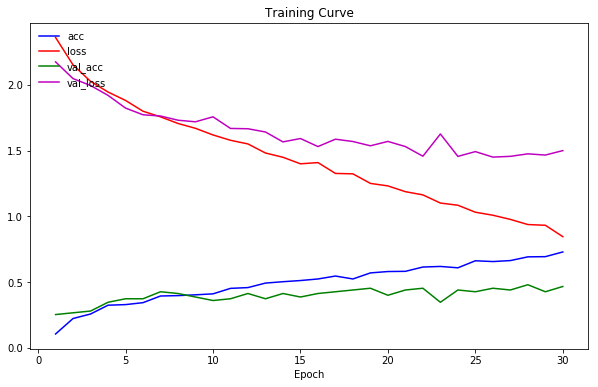

In [77]:
plot_traincurve(history)

### Testing

In [78]:
test_pred = model.predict_classes(test_set)

224/250 [=========================>....] - ETA: 0s

In [79]:
accuracy_score(test_classes, test_pred)

0.476

## Advanced Model: Additional Parameters & Techniques

Try:
* Adding Batch normalization
* Adding ReLU activation
* Adding Dropout

In [80]:
# Adapt parameters here:

conv_filters = 16   # number of convolution filters (= CNN depth), e.g. 16 or 32

batch_norm = True  # True or False

activation = 'relu' # sigmoid or relu

#dropout = None # None or 0 < dropout < 1
dropout = 0.25 # None or 0 < dropout < 1

In [81]:
model = Sequential()

# Layer 1
if batch_norm:
    model.add(BatchNormalization(input_shape=input_shape))
model.add(Convolution2D(conv_filters, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(Convolution2D(conv_filters, 4, 12, border_mode='valid', input_shape=input_shape))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(MaxPooling2D(pool_size=(1, 20))) 
if dropout:
    model.add(Dropout(dropout))

# Layer 2
if batch_norm:
    model.add(BatchNormalization())
model.add(Convolution2D(conv_filters, 3, 3, border_mode='valid', input_shape=input_shape))
model.add(Activation(activation)) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
if dropout:
    model.add(Dropout(dropout))

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
model.add(Activation(activation))
if dropout:
    model.add(Dropout(dropout))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(n_classes,activation='softmax'))

### Training

In [82]:
# Compiling the model

optimizer = 'sgd'

#learn_rate = 0.02
#optimizer = SGD(lr=learn_rate) #, momentum=momentum) 

model.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

history = None

In [83]:
# TRAINING the model - (you may repeat execution of this cell to FURTHER train the model!)
epochs = 30
History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
# we append this to previous history in case we execute this cell multiple times
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Epoch 1/30
747/747 [==============================] - 2s - loss: 2.5354 - acc: 0.1714     
Epoch 2/30
747/747 [==============================] - 2s - loss: 2.1651 - acc: 0.2236     
Epoch 3/30
747/747 [==============================] - 2s - loss: 2.0451 - acc: 0.2731     
Epoch 4/30
747/747 [==============================] - 2s - loss: 1.9882 - acc: 0.3066     
Epoch 5/30
747/747 [==============================] - 2s - loss: 1.9672 - acc: 0.3039     
Epoch 6/30
747/747 [==============================] - 2s - loss: 1.8823 - acc: 0.3320     
Epoch 7/30
747/747 [==============================] - 2s - loss: 1.8541 - acc: 0.3387     
Epoch 8/30
747/747 [==============================] - 2s - loss: 1.7940 - acc: 0.3762     
Epoch 9/30
747/747 [==============================] - 2s - loss: 1.7370 - acc: 0.3869     
Epoch 10/30
747/747 [==============================] - 2s - loss: 1.6890 - acc: 0.3909     
Epoch 11/30
747/747 [==============================] - 2s - loss: 1.6576 - acc: 0.4070   

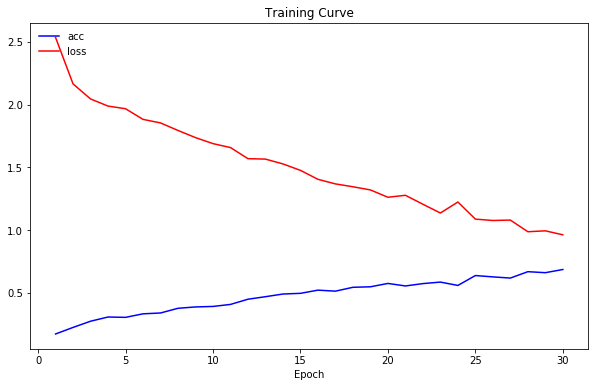

In [84]:
plot_traincurve(history)

### Testing

In [85]:
test_pred = model.predict_classes(test_set)

250/250 [==============================] - 0s     


In [86]:
accuracy_score(test_classes, test_pred)

0.476

In [87]:
print len(history['loss']), "epochs"

30 epochs


## Parallel CNNs

The motivation to use parallel CNNs is to use one CNN that detects patterns in the <b>frequencies</b> and another one that captures patterns in the <b>time domain, i.e. rhythm</b> in a combined way to learn better the structures in the sound.

To create parallel CNNs we need a "graph-based" model. In Keras 1.x this is realized via the functional API of the Model() class.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.

In [88]:
n_filters = 16  # e.g. 16 or 32 
dropout = 0.25 # None or 0 < dropout < 1

In [89]:
# Input only specifies the input shape
input = Input(input_shape)

# CNN layers
# specify desired number of filters

# The functional API allows to specify the predecessor in (brackets) after the new Layer function call
conv_layer1 = Convolution2D(n_filters, 10, 4, activation='relu')(input)  # a vertical filter
conv_layer2 = Convolution2D(n_filters, 4, 10, activation='relu')(input)  # a horizontal filter

# Pooling layers - equal sized
#maxpool1 = MaxPooling2D(pool_size=(2,2))(conv_layer1)
#maxpool2 = MaxPooling2D(pool_size=(2,2))(conv_layer2)

# ALTERNATIVE: Pooling layers - complementary to vertical/horizontal filter
#maxpool1 = MaxPooling2D(pool_size=(1,2))(conv_layer1)
#maxpool2 = MaxPooling2D(pool_size=(2,1))(conv_layer2)

# LARGER Pooling layers - complementary to vertical/horizontal filter
maxpool1 = MaxPooling2D(pool_size=(1,5))(conv_layer1)
maxpool2 = MaxPooling2D(pool_size=(5,1))(conv_layer2) # used 4,1 first

# Dropout for both layers
if dropout:
    maxpool1 = Dropout(dropout)(maxpool1)
    maxpool2 = Dropout(dropout)(maxpool2)

# we have to flatten the Pooling output in order to be concatenated
poolflat1 = Flatten()(maxpool1)
poolflat2 = Flatten()(maxpool2)

# Merge the 2 parallel pipelines
merged = merge([poolflat1, poolflat2], mode='concat')

full = Dense(256, activation='sigmoid')(merged)
output_layer = Dense(n_classes, activation='softmax')(full)

# finally create the model
model = Model(input=input, output=output_layer)

In [90]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 40, 80)     0                                            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 16, 31, 77)    656         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 16, 37, 71)    656         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 16, 31, 15)    0           convolution2d_7[0][0]            
___________________________________________________________________________________________

### Training

In [91]:
# Compiling the model

learn_rate = 0.02
optimizer = SGD(lr=learn_rate) #, momentum=momentum) 

model.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

history = None

In [92]:
# TRAINING the model (45 epochs, i.e. executing this block 3 times, worked well with this model)

epochs = 15
History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Epoch 1/15
747/747 [==============================] - 5s - loss: 2.1447 - acc: 0.2075     
Epoch 2/15
747/747 [==============================] - 5s - loss: 1.9319 - acc: 0.3400     
Epoch 3/15
747/747 [==============================] - 5s - loss: 1.8067 - acc: 0.3976     
Epoch 4/15
747/747 [==============================] - 4s - loss: 1.7162 - acc: 0.4311     
Epoch 5/15
747/747 [==============================] - 4s - loss: 1.6333 - acc: 0.4418     
Epoch 6/15
747/747 [==============================] - 4s - loss: 1.5468 - acc: 0.4766     
Epoch 7/15
747/747 [==============================] - 4s - loss: 1.4696 - acc: 0.5167     
Epoch 8/15
747/747 [==============================] - 4s - loss: 1.4151 - acc: 0.5167     - ETA: 4s - loss:
Epoch 9/15
747/747 [==============================] - 4s - loss: 1.3360 - acc: 0.5649     
Epoch 10/15
747/747 [==============================] - 4s - loss: 1.2823 - acc: 0.5904     
Epoch 11/15
747/747 [==============================] - 4s - loss: 1.2371

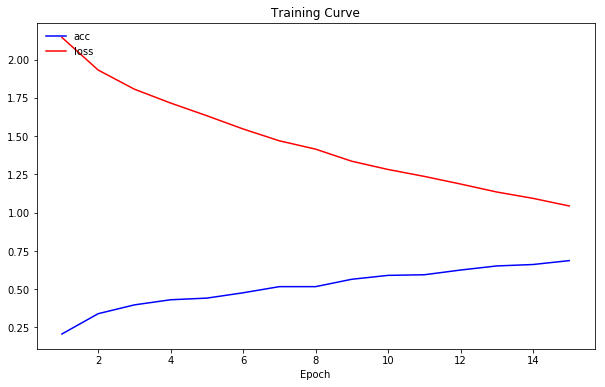

In [93]:
plot_traincurve(history)

### Testing

In [94]:
# THE GRAPH MODEL DOES NOT SUPPORT .predict_classes
# we use model.predict

test_pred = model.predict(test_set)

In [95]:
# it predicts the probabilities per class:
test_pred

array([[0.01008644, 0.48850468, 0.10271476, 0.08099674, 0.0159053 , 0.12473128, 0.00536835, 0.01528474, 0.07280622, 0.08360147],
       [0.03821958, 0.03675446, 0.31003594, 0.14895621, 0.03247003, 0.19420542, 0.00075596, 0.03698775, 0.02693672, 0.17467795],
       [0.02688367, 0.00587623, 0.02745439, 0.16636258, 0.04843133, 0.00496618, 0.5421363 , 0.00299422, 0.00447529, 0.17041978],
       [0.05265158, 0.01320518, 0.20393822, 0.07977491, 0.02001624, 0.27093962, 0.0031408 , 0.06983641, 0.16961685, 0.11688021],
       [0.00607668, 0.00313667, 0.04794782, 0.05062338, 0.21566004, 0.038432  , 0.01180089, 0.02408088, 0.50976956, 0.09247209],
       [0.01302967, 0.00245536, 0.0433457 , 0.38080552, 0.1736416 , 0.01304936, 0.07341395, 0.19924107, 0.01729607, 0.08372167],
       [0.01055614, 0.00047475, 0.01545255, 0.05978446, 0.75947136, 0.01990401, 0.02920137, 0.02585801, 0.04218941, 0.03710796],
       [0.02351544, 0.00604806, 0.04158041, 0.22619498, 0.04661018, 0.00802045, 0.49578038, 0.005

In [96]:
# we get the predicted class from the maximum value in the probabilities, using argmax to get the class number
test_pred = np.argmax(test_pred, axis=1)
test_pred

array([1, 2, 6, 5, 8, 3, 4, 6, 1, 5, ..., 2, 8, 2, 3, 2, 5, 4, 5, 9, 5])

In [97]:
accuracy_score(test_classes, test_pred)

0.52

## Further Practice

As a further practical learning, copy the models from above and try more adaptations:

* add more layers
* vary:
 * number of filters
 * filter sizes (shapes)
 * max pooling
 * activation functions: sigmoid, tanh, relu, prelu, elu, ...
* try other optimizers: 'from keras.optimizers import SGD, Adagrad, Adam' (RMSprop for binary or multi-label classification)